In [1]:
import sys
!{sys.executable} -m pip install deap


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, classification_report
from deap import base, creator, tools, algorithms
import random

# Load dataset (using the JM1 dataset as an example)
data = pd.read_csv('./cm1.csv')

# Drop any missing values
data = data.dropna()

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
# Define the evaluation function for the Genetic Algorithm
def evalFeatureSelection(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:
        return (0,)
    
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    return (accuracy,)

In [4]:
# Set up the Genetic Algorithm using DEAP

# Create the types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register the functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalFeatureSelection)



In [5]:
# Run the Genetic Algorithm for feature selection:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	min 	max
0  	50    	0.874133	0.86	0.9
1  	39    	0.874267	0.86	0.886667
2  	36    	0.875333	0.866667	0.893333
3  	30    	0.878533	0.86    	0.9     
4  	31    	0.883333	0.86    	0.9     
5  	36    	0.8876  	0.866667	0.9     
6  	27    	0.891067	0.853333	0.906667
7  	39    	0.894   	0.853333	0.906667
8  	22    	0.8988  	0.86    	0.906667
9  	28    	0.902133	0.873333	0.906667
10 	36    	0.9052  	0.873333	0.906667
11 	31    	0.903467	0.86    	0.906667
12 	31    	0.905067	0.873333	0.906667
13 	24    	0.904267	0.86    	0.906667
14 	33    	0.905733	0.873333	0.906667
15 	28    	0.9044  	0.866667	0.906667
16 	23    	0.904133	0.86    	0.906667
17 	19    	0.9056  	0.873333	0.906667
18 	34    	0.904667	0.866667	0.906667
19 	28    	0.904133	0.86    	0.906667
20 	30    	0.904667	0.873333	0.906667


In [6]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = hof[0]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Best individual: ", best_individual)
print("Number of selected features: ", len(selected_features))

Best individual:  [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Number of selected features:  8


In [7]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = KNeighborsClassifier()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9066666666666666
              precision    recall  f1-score   support

       False       0.91      1.00      0.95       134
        True       1.00      0.12      0.22        16

    accuracy                           0.91       150
   macro avg       0.95      0.56      0.59       150
weighted avg       0.92      0.91      0.87       150



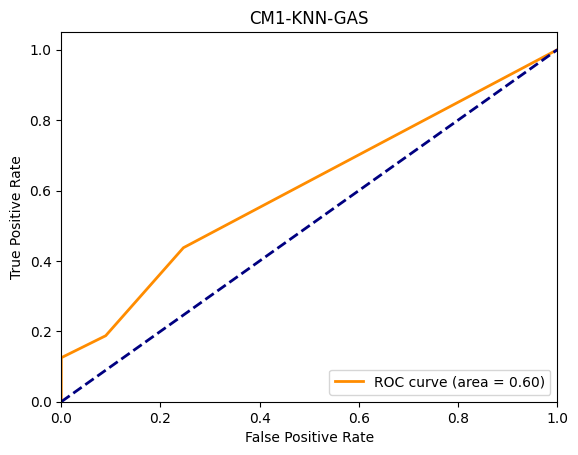

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/CM1/CM1_KNN_GAS.csv', index=False)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CM1-KNN-GAS')
plt.legend(loc="lower right")
plt.show()